### Removing duplicate triples when is obtained treatments by parallel codes

In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from rdflib import Graph

from collections import OrderedDict

In [2]:
#path = 'dataset/small_dataset/Study_2/'
path = ''

In [5]:
def save_ttl_file(graph_ttl, path):
    #open text file
    ttl_file = open(path + "G1_00.ttl", "w")
    #write string to file
    n = ttl_file.write(graph_ttl)
    #close file
    ttl_file.close()

In [6]:
graph_ttl = open(path + "G1.ttl").read()
graph_ttl = "\n".join(list(OrderedDict.fromkeys(graph_ttl.split("\n"))))
save_ttl_file(graph_ttl, path)

# Cross-Validation

In [3]:
g = Graph()
g.parse("G1.ttl", format="ttl")

<Graph identifier=N38076e7801d542eebd817b79ce4b04f2 (<class 'rdflib.graph.Graph'>)>

In [4]:
from rdflib.plugins.sparql.processor import SPARQLResult

def sparql_results_to_df(results: SPARQLResult) -> pd.DataFrame:
    """
    Export results from an rdflib SPARQL query into a `pandas.DataFrame`,
    using Python types. See https://github.com/RDFLib/rdflib/issues/1179.
    """
    return pd.DataFrame(
        data=([None if x is None else x.toPython() for x in row] for row in results),
        columns=[str(x) for x in results.vars],
    )

In [7]:
query = """PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example/#> 
PREFIX treatment_drug: <http://example/Treatment_Drug#>
    
select distinct ?treatment
where {
    ?treatment rdf:type ex:Treatment .
    ?treatment ex:hasClassificationEffect ex:effective .
    }
    """

qres = g.query(query)
#df_toxicity = pd.DataFrame(qres.bindings)
df_effective = sparql_results_to_df(qres)
df_effective['predicate'] = 'ex:hasClassificationEffect'
df_effective['object'] = 'ex:effective .'
#df_toxicity.replace('http://example/Treatment_Drug#', 'treatment_drug:', regex=True, inplace=True)

In [10]:
df_decrease_effectiveness

,treatment,predicate,object
0,http://example/Treatment/treatment0,ex:hasClassificationEffect,ex:decrease_effectiveness .
1,http://example/Treatment/treatment1,ex:hasClassificationEffect,ex:decrease_effectiveness .
2,http://example/Treatment/treatment2,ex:hasClassificationEffect,ex:decrease_effectiveness .
3,http://example/Treatment/treatment3,ex:hasClassificationEffect,ex:decrease_effectiveness .
4,http://example/Treatment/treatment4,ex:hasClassificationEffect,ex:decrease_effectiveness .
...,...,...,...
519,http://example/Treatment/treatment519,ex:hasClassificationEffect,ex:decrease_effectiveness .
520,http://example/Treatment/treatment520,ex:hasClassificationEffect,ex:decrease_effectiveness .
521,http://example/Treatment/treatment521,ex:hasClassificationEffect,ex:decrease_effectiveness .
522,http://example/Treatment/treatment522,ex:hasClassificationEffect,ex:decrease_effectiveness .


In [8]:
query = """PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example/#> 
PREFIX treatment_drug: <http://example/Treatment_Drug#>
    
select distinct ?treatment
where {
    ?treatment rdf:type ex:Treatment .
    ?treatment ex:hasClassificationEffect ex:decrease_effectiveness .
    }
    """
#<http://example/Treatment/treatment301>

qres = g.query(query)

#df_effectiveness = pd.DataFrame(qres.bindings)
df_decrease_effectiveness = sparql_results_to_df(qres)
df_decrease_effectiveness['predicate'] = 'ex:hasClassificationEffect'
df_decrease_effectiveness['object'] = 'ex:decrease_effectiveness .'
#df_effectiveness.replace('http://example/Treatment_Drug#', 'treatment_drug:', regex=True, inplace=True)

In [9]:
df_category = pd.concat([df_effective, df_decrease_effectiveness])
df_category['treatment'] = '<' + df_category['treatment'].astype(str) + '>'
display(df_category.head(2), df_category.shape)

,treatment,predicate,object
0,<http://example/Treatment/treatment524>,ex:hasClassificationEffect,ex:effective .
1,<http://example/Treatment/treatment525>,ex:hasClassificationEffect,ex:effective .


(580, 3)

In [10]:
df_category.reset_index(inplace=True)
df_category.drop(columns=['index'], inplace=True)
display(df_category.head(2), df_category.shape)

,treatment,predicate,object
0,<http://example/Treatment/treatment524>,ex:hasClassificationEffect,ex:effective .
1,<http://example/Treatment/treatment525>,ex:hasClassificationEffect,ex:effective .


(580, 3)

In [11]:
def cross_validation(dataset):
    test_set = []
    training_set = []
    X = dataset
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    kf.get_n_splits(X)
    
    split = 1
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        #print(len(test_index))
        #test_set.append(X.iloc[test_index])
        #training_set.append(X.iloc[train_index])
        test = X.iloc[test_index]
        test['object'] = test['object'].str.replace(' .', '')
        test.to_csv(path + 'G3/test_'+str(split)+'.ttl', sep='\t', index=False, header=False)
        create_training_set(split)
        split+=1

In [12]:
def create_training_set(split):
    with open(path + 'G3/test_'+str(split)+'.ttl', "r") as f:
        lines_test = f.readlines()
    with open(path + "G3.ttl", "r") as f:
        lines_data = f.readlines()
    with open(path + 'G3/train_'+str(split)+'.ttl', "w") as f:
        for line in lines_data:
            line = line.replace(' .', '')
            if line in  lines_test or '@prefix' in line:
                continue
            else:                
                f.write(line)

In [13]:
cross_validation(df_category)

C:\Users\rivasa\AppData\Local\Temp/ipykernel_14844/134286601.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  test['object'] = test['object'].str.replace(' .', '')
C:\Users\rivasa\AppData\Local\Temp/ipykernel_14844/134286601.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['object'] = test['object'].str.replace(' .', '')


In [63]:
g.serialize(destination="dataset/KG_treatment_serialize.ttl", format="ttl")

In [31]:
from platform import python_version

print(python_version())

3.9.7


In [8]:
from sklearn.model_selection import train_test_split

data_g1 = pd.read_csv('G1_data.ttl', delimiter="\t", header=None)
data_g1.columns=['s','p','o']
data_g1['o'] = data_g1['o'].str.replace(' .', '')
data_g1

C:\Users\rivasa\AppData\Local\Temp/ipykernel_23212/2858445035.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data_g1['o'] = data_g1['o'].str.replace(' .', '')


,s,p,o
0,ex:higher_toxicity,rdf:type,ex:HigherToxicity
1,ex:lower_effectiveness,rdf:type,ex:LowerEffectiveness
2,<http://example/Treatment/treatment0>,rdf:type,ex:Treatment
3,<http://example/Treatment/treatment0>,ex:hasClassificationEffect,ex:decrease_effectiveness
4,<http://example/Drug/DB00331>,rdf:type,ex:Drug
...,...,...,...
15112,treatment_drug:treatment579_DB00530,ex:hasLowerEffect,ex:lower_effectiveness
15113,ddi:treatment579DB00338DB00530,rdf:type,ex:DDI
15114,<http://example/Treatment/treatment579>,ex:related_to,ddi:treatment579DB00338DB00530
15115,ddi:treatment579DB00338DB00530,ex:precipitant_drug,<http://example/Drug/DB00338>


# Split set

In [4]:
train, test = train_test_split(data_g1, test_size=0.2)
test.to_csv('G2/test_1.ttl', sep='\t', index=False, header=False)
train.to_csv('G2/train_1.ttl', sep='\t', index=False, header=False)
display(train, test)

,s,p,o
15987,ddi:treatment535DB00958DB01050,ex:precipitant_drug,<http://example/Drug/DB00958>
15073,treatment_drug:treatment474_DB06186,rdf:type,ex:Treatment_Drug
15778,treatment_drug:treatment527_DB00584,ex:related_to,<http://example/Treatment/treatment527>
10274,treatment_drug:treatment216_DB00338,ex:related_to,<http://example/Drug/DB00338>
12829,treatment_drug:treatment327_DB00635,ex:related_to,<http://example/Drug/DB00635>
...,...,...,...
13369,ddi:treatment360DB00641DB01229,rdf:type,ex:DDI
4851,ddi:treatment58DB00338DB01229,ex:precipitant_drug,<http://example/Drug/DB00338>
5521,ddi:treatment71DB00335DB01076,ex:precipitant_drug,<http://example/Drug/DB00335>
10544,treatment_drug:treatment226_DB01248,ex:related_to,<http://example/Drug/DB01248>


,s,p,o
6859,treatment_drug:treatment105_DB00381,rdf:type,ex:Treatment_Drug
13212,treatment_drug:treatment351_DB01229,ex:hasLowerEffect,ex:lower_effectiveness
10880,ddi:treatment237DB00338DB00361,ex:precipitant_drug,<http://example/Drug/DB00338>
7828,ddi:treatment130DB00695DB00642,ex:object_drug,<http://example/Drug/DB00642>
15141,treatment_drug:treatment480_DB01229,ex:related_to,<http://example/Treatment/treatment480>
...,...,...,...
2627,ddi:treatment22DB01229DB00381,rdf:type,ex:DDI
1555,<http://example/Treatment/treatment9>,ex:related_to,ddi:treatment9DB00316DB01076
2278,treatment_drug:treatment18_DB00773,ex:related_to,<http://example/Treatment/treatment18>
4456,ddi:treatment52DB00361DB01233,ex:precipitant_drug,<http://example/Drug/DB00361>


# Cross-validation

In [76]:
def cross_validation(dataset):
    X = dataset
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    kf.get_n_splits(X)
    split = 1
    for train_index, test_index in kf.split(X):
        test = X.iloc[test_index]
        train = X.iloc[train_index]
        test.to_csv('G1/test_'+str(split)+'.ttl', sep='\t', index=False, header=False)
        train.to_csv('G1/train_'+str(split)+'.ttl', sep='\t', index=False, header=False)
        split+=1

cross_validation(data_g1)

NameError: name 'data_g1' is not defined

In [469]:
import matplotlib.pyplot as plt
def build_query(target):
    query = """PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX ex: <http://example/#> 
    PREFIX treatment_drug: <http://example/Treatment_Drug#>

    select distinct ?treatment (count(?o) as ?count_ddi)
    where {
        ?treatment rdf:type ex:Treatment .
        ?treatment ex:hasClassificationEffect ex:"""+target+""" .
        optional {?treatment ex:related_to ?o .}
        #optional { ?o rdf:type ex:DDI }
        } Group by ?treatment
        """
    return query

g2 = Graph()
g2.parse("G2.ttl", format="ttl")
g3 = Graph()
g3.parse("G3.ttl", format="ttl")

<Graph identifier=N5742c3edf19a4a1aa7dc0fe6be8d5823 (<class 'rdflib.graph.Graph'>)>

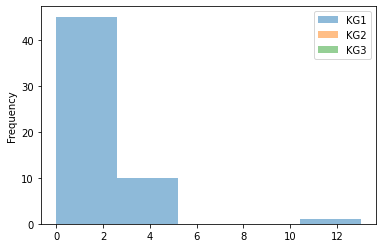

In [470]:
query = build_query('effective')
qres = g.query(query)
df_effective = sparql_results_to_df(qres)

df_plot = pd.DataFrame(columns=['KG1', 'KG2', 'KG3'])
df_plot['KG1']=list(df_effective.count_ddi)
#df = df_effective[['count_ddi']]
ax = df_plot.plot.hist(bins=5, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

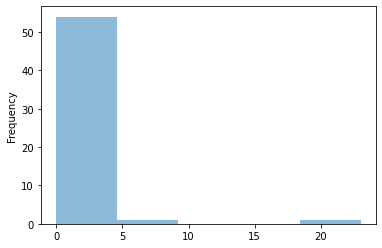

In [471]:
query = build_query('effective')
qres = g2.query(query)
df_effective = sparql_results_to_df(qres)

df_plot['KG2']=list(df_effective.count_ddi)
#df = df_effective[['count_ddi']]
df_plot['KG2'].plot.hist(bins=5, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

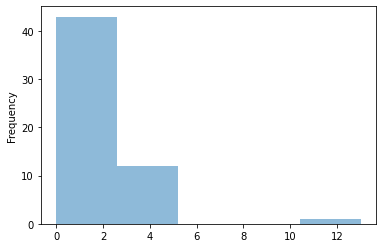

In [472]:
query = build_query('effective')
qres = g3.query(query)
df_effective = sparql_results_to_df(qres)

df_plot['KG3']=list(df_effective.count_ddi)
#df = df_effective[['count_ddi']]
df_plot['KG3'].plot.hist(bins=5, alpha=0.5)

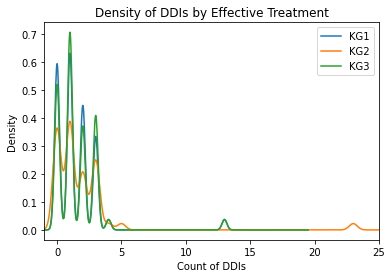

In [346]:
#df_plot['G2_effective']=list(df_effective.count_ddi)
ax = df_plot.plot.kde(bw_method=0.1)
ax.set_xlabel('Count of DDIs')
fig = ax.get_figure()
plt.xlim([-1, 25])
plt.title('Density of DDIs by Effective Treatment')
fig.savefig('Plots/Density_effective_treatment.pdf', format='pdf', bbox_inches='tight')

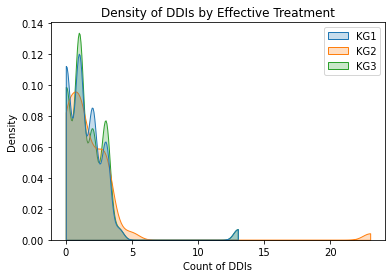

In [473]:
import seaborn as sns
ax = sns.kdeplot(cut=0,
   data=df_plot, shade=True, bw_adjust=.4,
)
ax.set_xlabel('Count of DDIs')
plt.title('Density of DDIs by Effective Treatment')
plt.savefig('Plots/Density_effective_treatment.pdf', format='pdf', bbox_inches='tight')

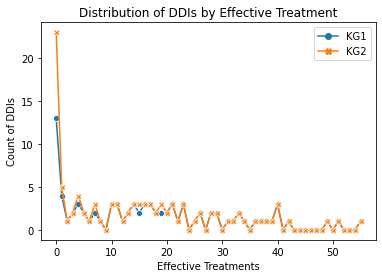

In [475]:
ax = sns.lineplot(data=df_plot[['KG1', 'KG2']], dashes=False, markers=True)
ax.set_xlabel('Effective Treatments')
ax.set_ylabel('Count of DDIs')
plt.title('Distribution of DDIs by Effective Treatment')
plt.savefig('Plots/Distribution_DDI_Effective_Treatment.pdf', format='pdf', bbox_inches='tight')

In [467]:
count = df_plot.loc[df_plot.KG2>df_plot.KG1].count()
count

KG1    6
KG2    6
KG3    6
dtype: int64

In [468]:
6/56

0.10714285714285714

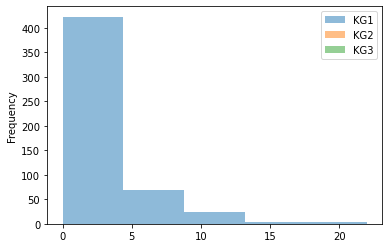

In [476]:
query = build_query('decrease_effectiveness')
qres = g.query(query)
df_effective = sparql_results_to_df(qres)

df_plot = pd.DataFrame(columns=['KG1', 'KG2', 'KG3'])
df_plot['KG1']=list(df_effective.count_ddi)
#df = df_effective[['count_ddi']]
ax = df_plot.plot.hist(bins=5, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

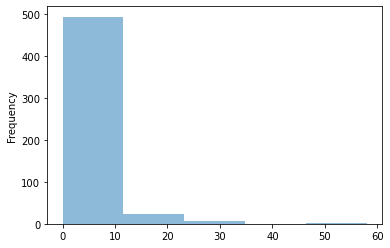

In [477]:
query = build_query('decrease_effectiveness')
qres = g2.query(query)
df_effective = sparql_results_to_df(qres)

df_plot['KG2']=list(df_effective.count_ddi)
#df = df_effective[['count_ddi']]
df_plot['KG2'].plot.hist(bins=5, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

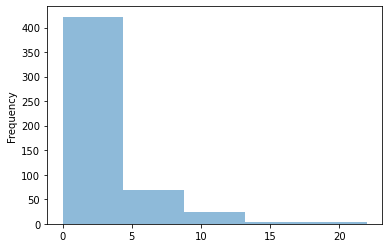

In [478]:
query = build_query('decrease_effectiveness')
qres = g3.query(query)
df_effective = sparql_results_to_df(qres)

df_plot['KG3']=list(df_effective.count_ddi)
#df = df_effective[['count_ddi']]
df_plot['KG3'].plot.hist(bins=5, alpha=0.5)

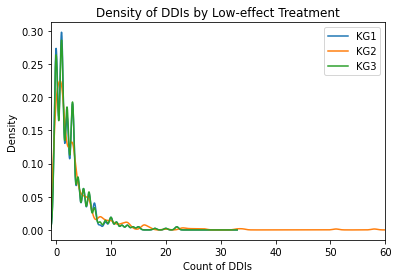

In [350]:
ax = df_plot.plot.kde(bw_method=0.1)
ax.set_xlabel('Count of DDIs')
fig = ax.get_figure()
plt.xlim([-1, 60])
plt.title('Density of DDIs by Low-effect Treatment')
fig.savefig('Plots/Density_decrease_effectiveness_treatment.pdf', format='pdf', bbox_inches='tight')

In [387]:
import numpy as np

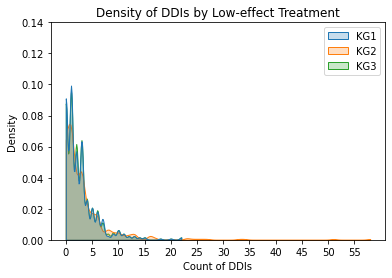

In [479]:
import seaborn as sns
ax = sns.kdeplot(cut=0,
   data=df_plot, shade=True, bw_adjust=.35,
)
ax.set_xlabel('Count of DDIs')
r1 = np.arange(0, 0.14, 0.02, float)
plt.yticks(r1)
#r2 = [x + 0.02 for x in r1]
r2 = np.arange(0, 60, 5, float)
plt.xticks(r2)

plt.title('Density of DDIs by Low-effect Treatment')
plt.savefig('Plots/Density_decrease_effectiveness_treatment.pdf', format='pdf', bbox_inches='tight')

In [400]:
# calculate the spearman's correlation between two variables
from scipy.stats import spearmanr

# prepare data
data1 = list(df_plot.KG1)
data2 = list(df_plot.KG2)
# calculate spearman's correlation
coef, p = spearmanr(data1, data2)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.994
Samples are correlated (reject H0) p=0.000


In [399]:
df_plot

,KG1,KG2,KG3
0,22,58,22
1,22,51,22
2,20,33,20
3,18,34,18
4,14,23,14
...,...,...,...
519,0,0,0
520,1,1,1
521,0,0,1
522,1,1,1


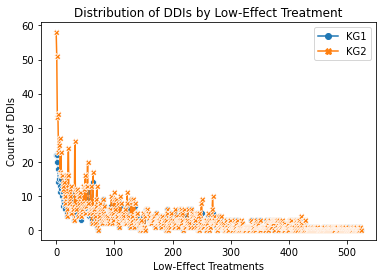

In [480]:
ax = sns.lineplot(data=df_plot[['KG1', 'KG2']], dashes=False, markers=True)
ax.set_xlabel('Low-Effect Treatments')
ax.set_ylabel('Count of DDIs')
plt.title('Distribution of DDIs by Low-Effect Treatment')
plt.savefig('Plots/Distribution_DDI_Low-Effect_Treatment.pdf', format='pdf', bbox_inches='tight')

In [459]:
count = df_plot.loc[df_plot.KG2>df_plot.KG1].count()
count

KG1    403
KG2    403
KG3    403
dtype: int64

In [461]:
121/524

0.23091603053435114